In [1]:
import pandas as pd
import os
import sys
import json
import matplotlib.pyplot as plt

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
from utils import *

aspects = [ 'actionability', 'grounding_specificity', 'verifiability', 'helpfulness']
# aspects = [ 'actionability', 'grounding_specificity', 'helpfulness']

# aspects = [ 'actionability']
types = ['definitions', 'definitions_examples', 'definitions_incontext_learning']
data_type = 'silver'
results = {}

## check if theres is file for each aspect
for aspect in aspects:
    try:

        if data_type == 'combined':
            df1 = pd.read_excel(f'../chatgpt/outputs/main_data_batch_gold_results.xlsx', sheet_name=aspect)
            df2 = pd.read_excel(f'../chatgpt/outputs/main_data_batch_silver_results.xlsx', sheet_name=aspect)
            results[aspect] = pd.concat([df1, df2], ignore_index=True)


        else:

            results[aspect] = pd.read_excel(f'../chatgpt/outputs/main_data_batch_{data_type}_results.xlsx', sheet_name=aspect)
        # results['verifiability'] =  pd.read_excel('outputs/two_step_verifiability_all_gold_chatgpt_output_min_examples.xlsx')
        print(f'File for {aspect} found')
    except:
        print(f'No file for {aspect}')

File for actionability found
File for grounding_specificity found
File for verifiability found
File for helpfulness found


In [2]:
results['verifiability'].columns

Index(['review_point', 'paper_id', 'venue', 'focused_review', 'batch',
       'verifiability', 'verifiability_label', 'id',
       'chatgpt_verifiability_extraction_score',
       'chatgpt_verifiability_extraction_rationale', 'prompt',
       'chatgpt_verifiability_score', 'chatgpt_verifiability_rationale'],
      dtype='object')

In [3]:
import json
confusion_matrices = {}
with open(f'outputs/human_chatgpt_{data_type}_agreement_results.txt', 'w') as f:
    for aspect, df in results.items():
        f.write(f'Agreement Statistics for {aspect}\n')
        f.write(f' Total number of samples: {len(df)}\n')
        ## get the prompt type
        
        prompt_type = 'definitions_incontext_learning'

        for type in [prompt_type]:
            gold_labels = []
            chatgpt_labels = []
            for index, row in df.iterrows():
                
                gold_label = row[f'{aspect}_label']
                chatgpt_label = row[f'chatgpt_{aspect}_score']
                chatgpt_label = str(chatgpt_label)
                if chatgpt_label.lower() in ['na','nan']:
                    continue

                ## if the labels are numeric, convert them to string
                if str(gold_label).lower() not in ['x', 'no claim']:
                    gold_label = str(int(float(gold_label)))
                else:
                    gold_label = 'X'
                if str(chatgpt_label).lower() not in ['x', 'no claim']:
                    ## extract the number from the string
                    chatgpt_label = ''.join(filter(str.isdigit, chatgpt_label))


                    chatgpt_label = str(int(float(chatgpt_label)))
                else:
                    chatgpt_label = 'X'

                gold_labels.append(gold_label)
                chatgpt_labels.append(chatgpt_label)

            f.write(f' Agreement Statistics for {type}\n')
            ## for verifiability we have one mroe measure
            results = get_stats(gold=gold_labels, pred=chatgpt_labels, aspect=aspect)
            f.write(json.dumps(results, indent=4) + '\n')
          

            ## print confusion matrix
            cm = confusion_matrix(gold_labels, chatgpt_labels)
            labels_order = sorted(set(gold_labels) | set(chatgpt_labels))
            print(f'Labels order: {labels_order}')
            confusion_matrices[aspect] = cm
            # display_labels = [1,2,3,4,5]
            # if aspect == 'verifiability':
            #     display_labels = display_labels + ['X']
            # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
            # print(f'Confusion Matrix for {aspect} {type}')
            # disp.plot()




            f.write('-' * 50 + '\n')
                
        f.write('=' * 50 + '\n')
        


Labels order: ['1', '2', '3', '4', '5']
Labels order: ['1', '2', '3', '4', '5']
Labels order: ['1', '2', '3', '4', '5', 'X']
Labels order: ['1', '2', '3', '4', '5']


In [4]:
cm

array([[ 11,  15,   2,   0,   0],
       [ 14,  34,  45,   3,   0],
       [  2,  35, 113,  34,   3],
       [  2,   6,  96,  72,  11],
       [  1,   9, 107, 157,  39]])

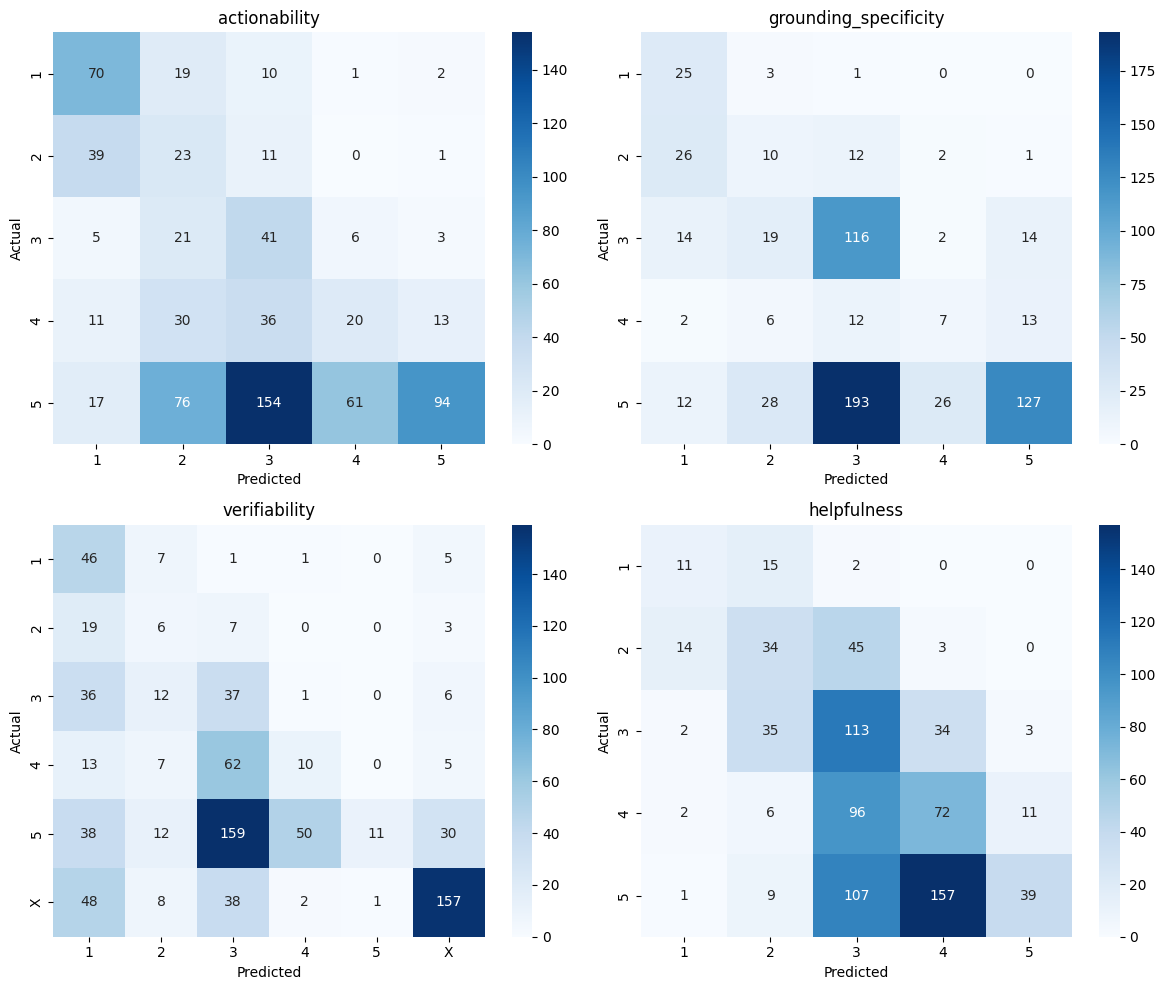

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each confusion matrix
for i, (title, matrix) in enumerate(confusion_matrices.items()):
    display_labels = [1, 2, 3, 4, 5]
    if title == 'verifiability':
        display_labels = display_labels + ['X']
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i], xticklabels=display_labels, yticklabels=display_labels)
    axes[i].set_title(title)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Adjust layout and show plot
plt.tight_layout()
plt.savefig(f'outputs/{data_type}_labels_confusion_matrices.pdf')
plt.show()
